# (1) Modelling #
## Setup ##

In [1]:
# For data manipulation
import pandas as pd, numpy as np

# For data visualization
from matplotlib import pyplot as plt
from IPython.display import display

# For various statistics
from scipy import stats

# For persisting model data to disk
try:
    import cPickle as pkl
except:
    import pickle as pkl
    
# For modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Load and Inspect Data ##

In [2]:
data = pd.read_csv('data.csv')
target_outcome = data['amount_returned'] / data['amount_invested'] - 1.0
target_outcome_twoclass = (target_outcome < 0.0) * 1

In [3]:
## Check the data types that pandas has inferred on the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 25 columns):
lien_id                         4000 non-null object
date_of_incident                2949 non-null object
plaintiff_law_firm              3444 non-null object
funder_name                     4000 non-null object
insurer_name                    1365 non-null object
plaintiff_law_firm_state        3354 non-null object
plaintiff_state                 3522 non-null object
case_state                      1873 non-null object
plaintiff_attorney_name         3730 non-null object
defendant_name                  1751 non-null object
case_type                       3215 non-null object
amount_invested                 4000 non-null float64
amount_returned                 4000 non-null float64
start_date                      4000 non-null object
end_date                        4000 non-null object
case_document_count             98 non-null float64
per_accident_liability_limit    3651 non-nul

In [4]:
## Assign fields to override the default 'object' treatment -- specifically categoricals and datetimes
categorical_fields = ['plaintiff_law_firm', 'funder_name', 'insurer_name', 'case_type', 'plaintiff_law_firm_state',
                     'plaintiff_state', 'case_state', 'defendant_name']

datetime_fields = ['date_of_incident', 'start_date', 'end_date', 'expected_settlement_date']

# We will have special handling of state fields to ensure they can be compared
state_fields = filter(lambda name: name.endswith('_state'), categorical_fields)

In [5]:
for field in categorical_fields:
    data[field] = data[field].astype('category')
    
for field in datetime_fields:
    data[field] = pd.to_datetime(data[field])
    
# Special handling of state fields to ensure they can be compared -- assign each to have categories equal to the superset
#   of categories in all state fields
state_categories = reduce(lambda acc, val: acc.union(data[val].cat.categories), state_fields, set())
for field in state_fields:
    data[field].cat.set_categories(state_categories, inplace=True)

### Continuous (Numerical) Features ###

In [6]:
data.describe(percentiles=[0.10,.25,.50,.75,.95]).T

,count,mean,std,min,10%,25%,50%,75%,95%,max
amount_invested,4000.0,3077.532458,6.808033e+03,100.0,524.50,790.0,1500.000000,3000.000000,10152.500,155624.16
amount_returned,4000.0,4333.035427,9.814540e+03,0.0,541.96,1000.0,2000.000000,4222.292500,14371.229,240000.00
case_document_count,98.0,5.530612,6.362266e+00,1.0,1.00,1.0,2.500000,8.000000,13.600,33.00
per_accident_liability_limit,3651.0,41146.261298,1.004957e+04,30000.0,30000.00,30000.0,40000.000000,50000.000000,50000.000,100000.00
expected_case_value,1634.0,337900.945936,1.100408e+06,0.0,15000.00,30000.0,60000.000000,200000.000000,1500000.000,30000000.00
effective_apr_first_year,4000.0,0.379909,9.593374e-01,-1.0,-1.00,0.2,0.438504,0.599186,2.000,3.00
number_liens_on_case,4000.0,4.876750,8.824995e+00,1.0,1.00,1.0,2.000000,4.000000,21.000,86.00
case_principal,4000.0,13297.323472,3.016047e+04,135.0,850.00,1650.0,3750.000000,11000.000000,60000.000,407250.00
attorney_instances_mighty,4000.0,27.906750,5.561513e+01,0.0,0.00,0.0,2.000000,26.000000,178.000,276.00
lawfirm_instances_mighty,4000.0,97.572500,1.681946e+02,1.0,2.00,3.0,35.000000,103.000000,612.000,775.00


#### Notes ####
* nearly all fields exhibit a lot of skew, and have a fat right tail -- at first glance most of these fields appear roughly gamma distributed
* case_document_count null is likely interpretable as 0 (zero) -- but will verify before assuming.  Fill rate is low enough that I'd question relying on any signal from this feature regardless, and interpretability is suspect given that I'm not sure how one can count 2.5 documents, or 13.6 documents.
* Notable that effective_apr_first_year clearly has continuous values, but enough of an excess of integer values for them to pop up in several percentiles in the data.  May be worthwhile to treat as a low-fill mixed-mode feature, with continuous and integer values separated into two columns

### Categorical Features ###

In [7]:
data.describe(include=[pd.Categorical, object]).T

,count,unique,top,freq
lien_id,4000,4000,1ddf680b-091c-466a-90e8-c9478ae82e1a,1
plaintiff_law_firm,3444,891,ce3a1fb6245bfa8dd,129
funder_name,4000,15,ad51d6fc62877643f,1372
insurer_name,1365,289,ee4e3cc38632c0d51,205
plaintiff_law_firm_state,3354,45,PA,1005
plaintiff_state,3522,46,PA,1019
case_state,1873,44,PA,729
plaintiff_attorney_name,3730,1284,8c96b2e66e1c74a7e,192
defendant_name,1751,1362,79c6aef3ec896149f,15
case_type,3215,30,Motor Vehicle Accident,1770


#### Notes ####
* There are many, *many* law firms -- so that won't be useful for modelling, though the frequency of the top one is high enough that we should at least encode the most common
* There are only 15 funders, so might be able to get meaningful variation
* Many insurers, though some are frequent -- worthwhile to encode most frequent
* PA clearly is the most common state, representing about half of the instances where we have case_state.  Will most likely be worthwhile to encode most frequent
* the 'state' fields are often null (particularly case_state) -- will include "null" as an encoded category for modelling
* Many attorneys, again some are frequent.  Will encode most frequent
* Defendant is usually unique, but some are repeats, with 13 having more than 5 entries (see below)
* Intriguingly, not every case has a type.  There is likely a taxonomy of case types that should be explicitly included, but I lack this information and so will for now default to encoding most frequent

Item for clarification: when one-hot encoding most frequent categorical features, we explicitly do not create an "other" bucket -- by not doing so we allow for interpretation of the model absent any inputs for that feature as the model for "Other", and then enable learning specific variations for each of the identified meaningful categories within the feature.  

In [8]:
print "Number of different plaintiff and law firm states:", 
print sum(np.logical_and(~data['plaintiff_state'].isnull(), 
                         data['plaintiff_law_firm_state'] != data['plaintiff_state']))

print "Number of different plaintiff and case states:",
print sum(np.logical_and(~data['case_state'].isnull(),
                         data['plaintiff_state'] != data['case_state']))

print "Number of defendants with > 5 entries:",
print sum(data['defendant_name'].value_counts() > 5)

Number of different plaintiff and law firm states: 456
Number of different plaintiff and case states: 44
Number of defendants with > 5 entries: 13


### Datetime Features ###

In [9]:
data.describe(include=[np.datetime64]).T

,count,unique,top,freq,first,last
date_of_incident,2949,2222,2007-04-10 00:00:00,5,1951-07-18 00:00:00,2015-06-24 00:00:00
start_date,4000,2667,2009-12-23 00:00:00,7,1993-02-01 00:00:00,2015-11-04 00:00:00
end_date,4000,2683,2010-05-08 00:00:00,8,1993-05-03 00:00:00,2017-04-10 00:00:00
expected_settlement_date,1328,1124,2009-10-06 00:00:00,3,2000-09-14 00:00:00,2017-04-14 00:00:00


#### Notes ####
* Incident date range from 1951 through 2015
 * Wide range of dates may indicate a need to control for changes in law / behavior over time
 * Need to look at the distribution ov events across that time frame and potentially filter to remove outliers
 * Intriguingly, all start dates are 1993 on, and all expected settlement dates are 2000 on.
* For consistency, I will exclude data from pre-2000, however this is fairly arbitrary.  In practice, any exclusions would have to be done on the basis of consultation with experts in the space under their guidance on periods where law was materially different, or alternatively using optimization to select the date.

In [10]:
old_map = map(lambda dt: dt.year < 2000, data['date_of_incident'])
print "Pct of incident dates before 2000: %.2f%%" % (100 * sum(old_map) 
         / float(sum(np.logical_not(data['date_of_incident'].isnull()))))

Pct of incident dates before 2000: 4.85%


In [11]:
print "Filtering incident dates before 2000...",
selector = np.logical_not(old_map)
data = data.loc[selector]
target_outcome = target_outcome[selector]
target_outcome_twoclass = target_outcome_twoclass[selector]
print "Done"

Filtering incident dates before 2000... Done


### Quick review of outcome distribution ###

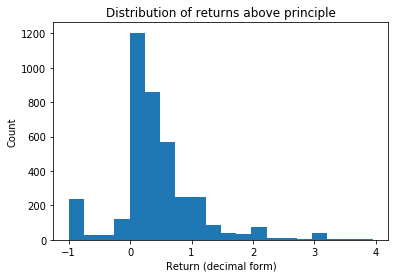

% Unsuccessful: 10.9%


count    3857.000000
mean        0.412095
std         0.662078
min        -1.000000
25%         0.128721
50%         0.299310
75%         0.648204
max         3.953333
dtype: float64

In [12]:
plt.hist(target_outcome, bins=20)
plt.title("Distribution of returns above principle")
plt.xlabel("Return (decimal form)")
plt.ylabel("Count")
plt.show()
print "%% Unsuccessful: %.1f%%" % (100.0 * sum(target_outcome < 0.0) / float(target_outcome.shape[0]))
target_outcome.describe().T

### Notes ###
* Relatively sparse class problem (89.1% successful vs unsuccessful frequency)
 * Not dramatically rare, so don't need to treat as a rare-event problem
 * Treating as classification problem likely to be aided by class weighting or synthetic rare-class upsampling (i.e. SMOTE)
 * Treating as regression problem on the returns above principle is likely to behave better, but need to construct the loss function to emphasize correctness near zero, and deemphasize errors distant from zero
* Will explicitly create both regression and classification models and compare under cross validation

### Review categoricals for likely relationship with outcome ###
For each categorical field, we would like to identify those categories which, when you split the population based on them vs rest, lead to a materially different distribution on the outcome variable (returned / principle).  A couple of notes:
* Realistically, 4k observations will not be enough to make this generalize reliably or produce robust p-values
* The alternative if we treat this as a true categorical problem is to calculate the enrichment for each category across the successful/unsuccessful boundary for the outcome, however this will not generalize as well to the regression case as the reverse, and with the class imbalance the hypothesis test would be even less rubust, and therefore the KS test is preferred on first blush even though it may capture some irrelevant relationships
* I will be using a 99.9% confidence level for the cutoff on the KS test to restrict the size of the resulting generated features.  This is a tunable hyperparameter to this process and, in practice, should be optimized.

In [13]:
field_categories_to_encode = {}

for field in categorical_fields:
    field_data = data[field]
    if 'NULL' not in field_data.cat.categories:
        field_data.cat.add_categories('NULL', inplace=True)
    field_data[field_data.isnull()] = 'NULL'
    counts = field_data.value_counts()
    ks_stats = pd.Series(np.nan, index=counts.index, name="KS p-value (this vs rest of outcome)")
    for cat in counts.index:
        ks_stats[cat] = stats.ks_2samp(target_outcome[field_data == cat], target_outcome[field_data != cat] )[1]
    field_categories_to_encode[field] = list(ks_stats.index[np.argwhere(ks_stats <= 0.0001).flatten()].values)
    x = pd.concat([counts, ks_stats], axis=1).sort_values(ks_stats.name)
    orig_len = x.shape[0]
    x = x[x[ks_stats.name] < 0.025]
    x.loc[x[ks_stats.name] < 0.0001, ks_stats.name] = "< 0.0001"
    print "## %s ##" % field
    display(x)
    if orig_len > x.shape[0]:
        print "... And %i more" % (orig_len - x.shape[0])
    print ""

## plaintiff_law_firm ##


/home/beakin/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:4750: RuntimeWarning: invalid value encountered in true_divide
  cdf1 = np.searchsorted(data1, data_all, side='right') / (1.0*n1)
/home/beakin/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:4756: RuntimeWarning: divide by zero encountered in double_scalars
  prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)


,plaintiff_law_firm,KS p-value (this vs rest of outcome)
53f6957844e1ae981,50,< 0.0001
be038e71c2d1cb08f,22,< 0.0001
ce3a1fb6245bfa8dd,129,< 0.0001
1c38c177c9e9258a5,27,< 0.0001
f3a6739e81565e2f7,47,< 0.0001
7edaf423272191ba3,32,< 0.0001
c886675fde241cef4,20,< 0.0001
ccf1ef0b7633695d2,8,< 0.0001
50f4cb01d5db61b5d,7,< 0.0001
a4201f5c51de5f836,57,< 0.0001


... And 827 more

## funder_name ##


,funder_name,KS p-value (this vs rest of outcome)
bbfd6b1bcbbfdcfc0,467,< 0.0001
ad51d6fc62877643f,1342,< 0.0001
864cc29e5f7a96fd7,122,< 0.0001
6e72dbf89c787396a,907,< 0.0001
7c316dffe49f24f2e,141,< 0.0001
a010e6f6a4cf8fe1f,119,< 0.0001
79117e7b76ca284ce,419,< 0.0001
a3976054cbbd374bb,104,< 0.0001
4abebd35f6d2b01c9,53,0.00752552


... And 7 more

## insurer_name ##


,insurer_name,KS p-value (this vs rest of outcome)
NULL,2529,< 0.0001
79c6aef3ec896149f,68,0.000661655
f97838912c8fdfb0d,9,0.00195138
1051068f90f767690,78,0.0024246
2fba74296962386b7,5,0.00367974
60218f9b28aa1603d,2,0.0125115
896ee677ba22852d0,2,0.016189
a7bedee47b503d55a,4,0.0205976
79cce21c7cefd79d1,47,0.02323


... And 281 more

## case_type ##


,case_type,KS p-value (this vs rest of outcome)
Motor Vehicle Accident,1716,< 0.0001
Labor Law,14,0.000142322
Premises Liability,152,0.000562883
Settled Case,69,0.000983789
Civil Rights,21,0.00135883
NULL,772,0.00184256
Other,332,0.00263668
Slip and Fall,173,0.0103253


... And 23 more

## plaintiff_law_firm_state ##


,plaintiff_law_firm_state,KS p-value (this vs rest of outcome)
MI,341,< 0.0001
PA,986,< 0.0001
NY,445,< 0.0001
GA,304,< 0.0001
MO,118,< 0.0001
NULL,626,< 0.0001
FL,255,0.000420803
IL,25,0.0168836
MS,2,0.0192332


... And 42 more

## plaintiff_state ##


,plaintiff_state,KS p-value (this vs rest of outcome)
MI,302,< 0.0001
PA,1002,< 0.0001
NY,471,< 0.0001
GA,388,0.000137835
AR,10,0.000351677
NULL,474,0.00121865
NC,11,0.00295991
IL,30,0.00326863
MN,25,0.00582371
FL,176,0.0107611


... And 40 more

## case_state ##


,case_state,KS p-value (this vs rest of outcome)
MI,292,< 0.0001
PA,726,< 0.0001
NY,174,< 0.0001
NULL,2071,< 0.0001
DE,22,0.00135278
MN,23,0.00216989
IL,16,0.00425578
FL,146,0.00556248
AR,11,0.0140113


... And 42 more

## defendant_name ##


,defendant_name,KS p-value (this vs rest of outcome)
b0c9d0baf9842cb1a,14,< 0.0001
26498446d3c4465d1,5,< 0.0001
95866c56ba17e882c,5,0.000131625
9e5ca9c29d4087f32,4,0.00034996
cb7d7c1e4afc4eb3b,4,0.000423773
NULL,2191,0.000736231
faaba0084e900abed,4,0.00182916
bc2e7e5b3e8f554b3,3,0.00222022
7a18d7820345ca2d2,3,0.002832
5c3d37bb1f59a5035,3,0.00586087


... And 1338 more



In [14]:
print "Number of categorical values to onehot encode (excluding \"Other\" buckets)", 
print sum(map(len, field_categories_to_encode.itervalues()))

Number of categorical values to onehot encode (excluding "Other" buckets) 38


#### Sample of distributional variation for top KS p-value category in each feature ####

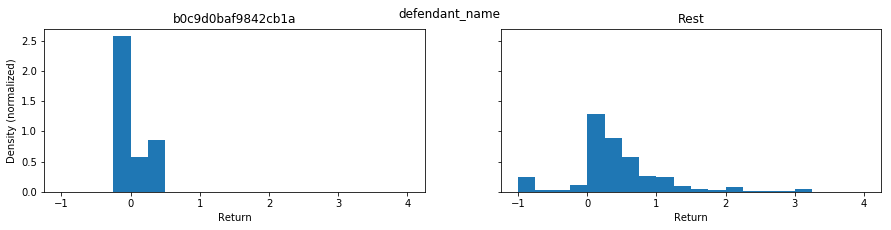

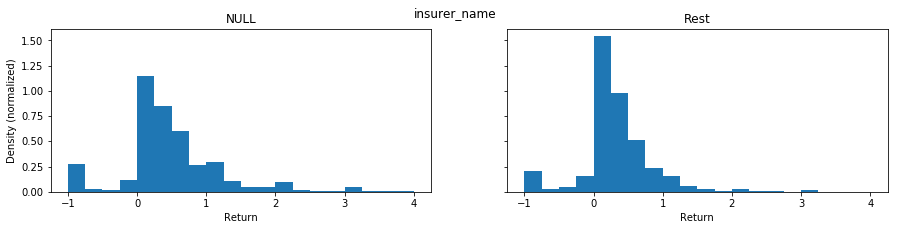

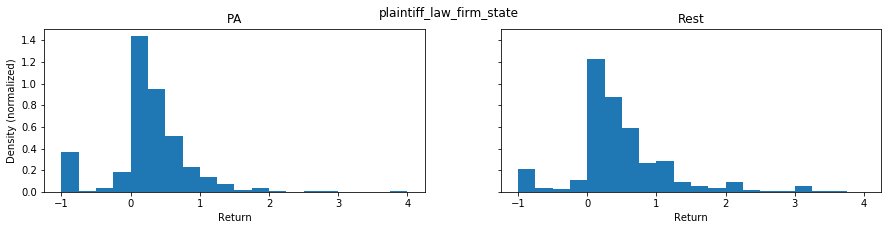

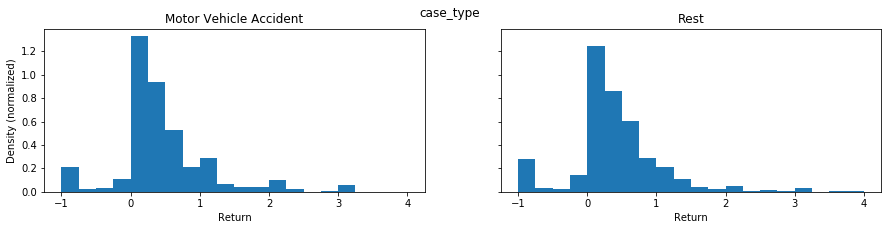

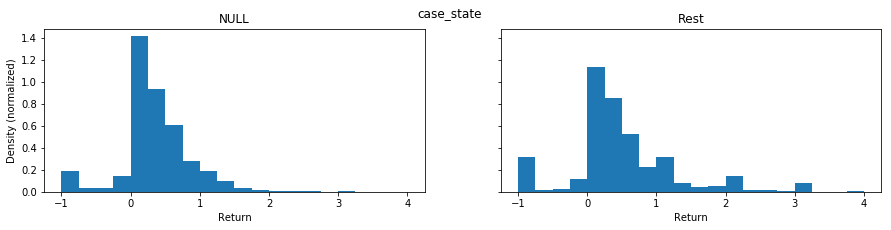

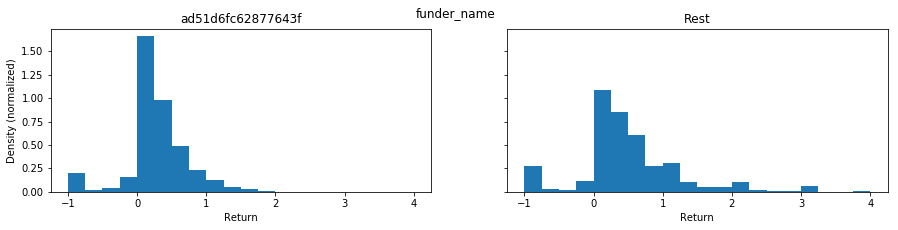

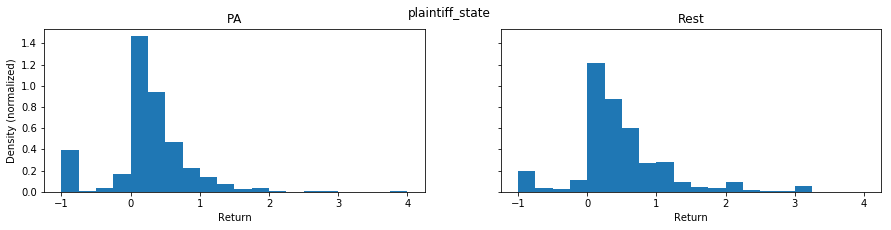

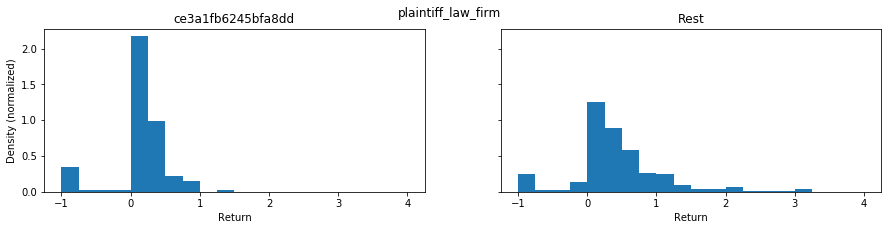

In [15]:
for field, top_cats in field_categories_to_encode.iteritems():
    top_cat = top_cats[0]
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,3))
    f.suptitle(field)
    ax1.hist(target_outcome[data[field] == top_cat], bins=20, range=(-1.0, 4.0), normed=True)
    ax1.set_title(top_cat)
    ax1.set_ylabel('Density (normalized)')
    ax1.set_xlabel('Return')
    ax2.hist(target_outcome[data[field] != top_cat], bins=20, range=(-1.0, 4.0), normed=True)
    ax2.set_title("Rest")
    ax2.set_xlabel('Return')
    plt.show()

### Generate data set for modelling ###

Major steps:

* Feature engineering
* Train/Test Split
* Null filling
* Outlier/anomaly detection and cleaning
* Persisting values determined on training data for later use

#### Notes ####

* **Feature Engineering** 
 * Many of the fields are collinear, so in a production setting we would want to engineer these in a more orthogonal way (a set of ratios along with a single scale column).  This will improve generalizability out of sample, particularly for simpler models, and will make sensitivity analysis more meaningful.  However, given that this is best done with strong knowledge of the underlying business, I have opted to stick with the features in their original space and use model(s) which are relatively tolerant to the collinearity.
 * I have simply onehot encoded the individual values of categoricals which, in a statistically significant way, separate the cases into differently distributed outcome populations.  In practice, it would be preferred to first see if there is an effect simply from the frequency of experience with that defendant/law firm/insurer/et cetera.  This would most likely take the form of either explicitly testing for a maximal split of the population at various percentiles in the experienced frequencies.  Finally, onehot encodings of the individual categories would then best be limited to those that lead to a difference in the distribution of the *residuals* of a model without the onehot encodings, rather than on differences in the distribution of outcomes, to avoid encoding information already captured by the existing features.  This issue will be less relevant with a larger data set, but still meaningful
* **Null filling** will be relatively rudamentary -- generally this would be ok with the more robust feature engineering described above, but it will introduce some bias and reduce out of sample performance without that.
* **Outlier/anomaly detection** will not be done in a systematic way for this exercise as determining the manner most appropriate for this data set is difficult on the sample size, and would not materially change the expected performance given the observed distributions.  Happy to discuss how I would handle this in practice.

In [16]:
# can't include for modelling
exclude_features = ['amount_returned']

modelling_data = pd.concat(
    [data._get_numeric_data()]
    + [pd.get_dummies(data[field], prefix=field)[["%s_%s" % (field, cat) for cat in cat_list]] 
       for field, cat_list in field_categories_to_encode.iteritems()], axis=1)

if len(set(exclude_features).intersection(modelling_data.columns)) > 0:
    modelling_data.drop(set(exclude_features).intersection(modelling_data.columns), axis=1, inplace=True)

In [17]:
modelling_data.describe().T

,count,mean,std,min,25%,50%,75%,max
amount_invested,3857.0,3057.702199,6.868536e+03,100.0,750.0,1500.000000,2905.000000,155624.16
case_document_count,98.0,5.530612,6.362266e+00,1.0,1.0,2.500000,8.000000,33.00
per_accident_liability_limit,3512.0,41146.070615,1.014298e+04,30000.0,30000.0,40000.000000,50000.000000,100000.00
expected_case_value,1573.0,311311.281411,1.052349e+06,0.0,30000.0,60000.000000,200000.000000,30000000.00
effective_apr_first_year,3857.0,0.337615,9.359517e-01,-1.0,0.0,0.430476,0.555385,3.00
number_liens_on_case,3857.0,4.889811,8.918810e+00,1.0,1.0,2.000000,4.000000,86.00
case_principal,3857.0,13194.454410,2.986834e+04,135.0,1555.0,3750.000000,10800.000000,407250.00
attorney_instances_mighty,3857.0,28.482499,5.620498e+01,0.0,0.0,3.000000,27.000000,276.00
lawfirm_instances_mighty,3857.0,99.863106,1.704884e+02,1.0,3.0,36.000000,104.000000,775.00
number_case_notes,3857.0,6.893959,1.699760e+01,0.0,0.0,0.000000,6.000000,226.00


#### Test Train Split ####
We will use a 80/20 train/test split for analysis and validation.  In practice, we would want to use cross validation to get a lower bound for out-of-sample performance, and to reestimate on a roll-forward basis to determine the risk of temporal discontinuities in the data. 

In [18]:
test_pct = 0.2

# Use random seed for reproducibility.
#    Random seed chosen by fair dice roll, guaranteed to be random: https://xkcd.com/221/
split = train_test_split(modelling_data, target_outcome, target_outcome_twoclass, 
                         random_state=4, test_size=test_pct)

split = [x.copy() for x in split]
train_X, test_X, train_Y, test_Y, train_Y_twoclass, test_Y_twoclass = split

#### Null Filling ####
We will use to fill nulls for certain fields, and for the remainder will use the median (or mode for onehot encoded, though this is calculated using the nanmedian function for simplicity).  In practice, we should consider each field and whether, for example, it should be null filled with a value which is conditioned on a field which indicates the size of the case.  However, given my limited time and access to underwriters, I have chosen median filling for the moment for simplicity.

In [19]:
zero_fill_columns = ['case_document_count']

fill_values = {field: 0 for field in zero_fill_columns}

for field in set(train_X.columns).difference(zero_fill_columns):
    fill_values[field] = np.nanmedian(train_X[field])

In [20]:
with open('./null_vill_values.pkl', 'w') as f:
    pkl.dump(fill_values, f)

In [21]:
def fill_df(df, value_map):
    for field in df.columns:
        df.loc[df[field].isnull(), field] = value_map[field]
        
fill_df(train_X, fill_values)
fill_df(test_X, fill_values)

In [22]:
# Create general purpose routine to compare predictions from models
def display_results(yhat, model_name):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    
    f.suptitle(model_name)
    
    fpr, tpr, threshold = metrics.roc_curve(test_Y_twoclass, y_hat)
    roc_auc = metrics.auc(fpr, tpr)

    ax1.set_title('ROC curve')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.legend(loc='lower right')
    ax1.plot([0,1], [0,1], 'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    precision, recall, thresholds = metrics.precision_recall_curve(test_Y_twoclass, y_hat)
    ap_score = metrics.average_precision_score(test_Y_twoclass, y_hat, average='weighted')

    ax2.set_title('Precision/Recall Curve')
    ax2.step(recall, precision, 'b', label = 'AP = %.2f' % ap_score, where='post')
    ax2.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    ax2.legend(loc='upper right')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1.05])
    ax2.set_ylabel('Precision')
    ax2.set_xlabel('Recall')
    
    plt.show()

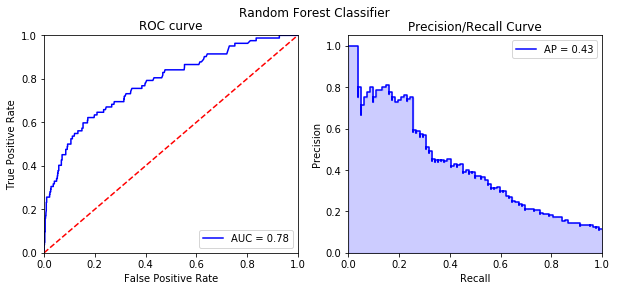

In [23]:
# We prefer to use many trees to ensure out of sample generalizability
model = RandomForestClassifier(n_estimators=1000,
                               random_state=4)
model.fit(train_X, train_Y_twoclass)
y_hat = model.predict_proba(test_X)[:, 1]

display_results(y_hat, "Random Forest Classifier")

### Model Evaluation - Notes ###
* For ordinal comparison of the predictive power of a two-class model like this with highly imbalanced classes, I prefer average precision (AP) -- however the value in and of itself is not readily interpretable.
* AUC is more directly interpretable (also directly convertible into the sometimes preferred Gini coefficient)
* Realistically, the correct comparison for any two-class model will be dependent on the actual cost of false positives vs false negatives.  Presumably, given limited capital, there would be a preference for conservativeness -- i.e. a higher cost to false negatives than false positives (given the 'true' class is encoded as an 'unsuccessful' lien).

# (2) Factors Affecting Lien Valuation #
The major factors affecting the value of a lien would be expected to be:
* Size of the lien
* Expected size of the payout
* Number of more senior liens on the case
* Interest rate
* Length of time expected before the payout
* Probability of payout
* Known Senior Liens
* Cost of capital
* Liquidity (possibly specific to each lien given heterogenous nature of the space)

Of these, size of the lien, interest rate, and expected payout are known, and probability of the payout was addressed in part (1) above.  The work necessary to estimate value and look at partial sensitivities is beyond the scope of this exercise.  However, we can look at the major factors extracted as part of that probability of success model.

### Major Contributors to Success ###

In [24]:
x = sorted(zip(model.feature_importances_, modelling_data.columns), reverse=True)

success = target_outcome_twoclass == 0.0
non_success = np.logical_not(success)

def descriptor(pct, name):
    if len(modelling_data[name].unique()) > 2:
        succ_text = "Success avg: %.2f" % np.nanmean(modelling_data.loc[success, name])
        nosucc_text = "Non-Success avg: %.2f" % np.nanmean(modelling_data.loc[non_success, name])
    else:
        succ_text = "True w/ Success: %.1f%%" % (100 * np.nanmean(modelling_data.loc[success, name]))
        nosucc_text = "True w/ Non-Success: %.1f%%" % (100 * np.nanmean(modelling_data.loc[non_success, name]))
        
    return " | ".join([
        ("%.1f%%: %s" % (pct * 100, name)).ljust(45),
        succ_text.ljust(25),
        nosucc_text])

print "Top 20 Contributors to the model:\n"
print "\n".join(map(lambda item: descriptor(*item), x[:20]))

Top 20 Contributors to the model:

15.0%: case_principal                         | Success avg: 13297.23     | Non-Success avg: 12353.39
13.8%: amount_invested                        | Success avg: 3112.79      | Non-Success avg: 2606.88
10.0%: lawfirm_instances_mighty               | Success avg: 98.59        | Non-Success avg: 110.28
9.2%: attorney_instances_mighty               | Success avg: 26.38        | Non-Success avg: 45.73
8.8%: number_case_notes                       | Success avg: 6.47         | Non-Success avg: 10.37
8.5%: number_liens_on_case                    | Success avg: 4.74         | Non-Success avg: 6.10
8.1%: effective_apr_first_year                | Success avg: 0.34         | Non-Success avg: 0.30
5.1%: expected_case_value                     | Success avg: 299498.33    | Non-Success avg: 413496.93
2.7%: case_type_Motor Vehicle Accident        | True w/ Success: 45.2%    | True w/ Non-Success: 38.6%
2.6%: per_accident_liability_limit            | Success avg: 4

### Notes ###
* Successful cases tend to be larger (presumably greater due diligence or resources devoted, but would need research)
* Successful cases tend to involve attorneys Mighty has seen fewer times
* Successful cases tend to have fewer liens, and higher first year apr
* Interestingly, successful cases have a lower indicated expected case value, though this could indicate less riskiness
* In general, better to get a plaintiff law firm in NY than PA

# (3) Proposed Lien Valuation Model #
I have already listed in (2) above the factors which I believe would affect lien value.  To construct an effective lien value model, I would fundamentally start treating it as a high yield fixed income instrument.  From this perspective, we capture a few major components to model separately:
* Likelihood of payout
* Size of payout
* Time to payout
Each of the above models would need to be probabilistic, and feed a distribution over possible returned capital at various points in time.

Now, the longer that capital is likely to be locked up, the higher the opportunity cost, which means we have to consider that distribution relative to the expected distribution for a lien with a similar risk profile.  This allows us to explicitly adjust the valuation for the additional (or reduced) liquidity risk taken compared to baseline.

Finally, liens don't exist in a vacuum.  Concentration risk is, of necessity, an element in valuation in a portfolio like this.  It is clear, for example, that a large portion of the data is in Pennsylvania.  Concentration in a single state, and particularly in a single jurisdiction increases the risk that changes in the law, or a judge, or a political party can lead to changes in the risk profile for an entire segment of your portfolio simultaneously, what might be called 'correlation risk'.  As such, part of the valuation must be a portfolio analysis under stress scenarios which assume significant reductions in payout size or likelihood across a given jurisdiction.  If handled correctly, the imposed cost of capital would naturally increase as concentration increased for a geography (or other relevant factor -- I don't mean to pick on geography, it just is illustrative).  As such, this would be a natural way to help balance the portfolio against factors that could lead to systematic shocks.

## Additional Data ##
Ideally we would collect data on the specific jurisdiction in which each case was handled, or even what judge was presiding.  Additionally while case notes counts and document counts are interesting, far more interesting would be raw text with the resulting ability to do simple NLP.  Additionally, while the number of total liens is a line item, it is unclear the dollar amount of those liens or their seniority relative to this lien.  The dollar amount of liens more senior than ours is a key input into the distribution of expected cash flows.

In an even more ideal world, we would collect the data on medical liens that are actually sold in the market today and use these as a baseline for evaluating our model.

## Evaluation Criteria ##
The simplest way to evaluate a valuation model before you deploy it is, of course, through adjusting actual aggregate cash flows on historical liens for the cost of capital you experience, and determining if after paying what you value them at still earn net positive profit.  On a more granular scale, each component would need to be evaluated:

### Likelihood of payout ###
In general I prefer Brier score for analyzing the behavior of probability estimates like this.  It's a very reasonable way to determine whether the probability estimates correspond roughly to the local experience of similar data points.  I would also recommend a banded approach, looking at deciles based on the PD predictions and validating both ordinality in true probability of payout, and that the true probability roughly matches the expected probability.  Calibration may be necessary if the latter is untrue.

### Size of payout ###
I prefer to explicitly model the 10th, 50th and 90th percentiles as an approximation of the distribution here.  A gamma distribution, or possibly a skew-normal distribution would be matched to the prediction for each lien, and the resulting parameters to the distribution would be stored.  One appropriate way to approach evaluating that this is behaving is to take the observations as percentiles from the predicted distribution function and then run a chi squared test to determine whether the percentiles are uniformely distributed.  Each of the three percentile models would separately be validated using a weighted loss function that penalized errors appropriately to keep the correct number of over and under estimations on either side over time.  I would need to think more about how to construct these and the most appropriate manner for evaluating goodness of fit.  

### Time to payout ###
I would mirror my statements about size of payout here -- broadly it is a distribution, and that can be modelled by targetting specific percentiles and constructing the loss functions appropriatelly, and then fitting a meaningful distribution to those predicted percentiles.

### Final Model ###
Ultimately the final model has to be judged based on average economic profit across the portfolio.  If the individual components are correct, then the final model can't really be judged except on correctness of form, and reflectiveness of firm risk tolerance under stress.  The latter, of course, means that stress testing, both scenario and monte carlo based, are the best options for understanding the range of risks and determining whether they both reflect firm risk tolerance and are reflective of experience.  Over time, statistics on these stress tests should be taken, compared to experience, and used to adjust risk parameters, with the understanding that we have to make the models conservative by design.  